In [1]:
import os 
import time
import copy

import resnet as rnet

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle

using device cuda:0


In [2]:
path = !pwd
path = path[0]
print(path)
mdl_savefile = path+"/models/resnet56_cumultrain_parameters.pickle"
mdl_loadfile = mdl_savefile

/home/ola/Documents/DD2424project


### Functions 

In [3]:
def show_model(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()

def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]

def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 

def update_results(n_vbatches=1):
    f"updates loss and accuracy for training and validation" 
    global mom_track
    global lr_track
    global accu_tr
    global accu_val
    global loss_tr
    global loss_val
    mom_track += [optimizer.param_groups[-1]['momentum']]
    lr_track  += [optimizer.param_groups[-1]['lr']]
    accu_tr   += [get_xent_acc(prediction, labels)]
    loss_tr   += [output.data.cpu().numpy().item()]
    with torch.no_grad():
        network.eval()      
        accu, loss = 0, 0
        for i, (imgs_val, labels_val) in enumerate(dataloader_vl):
            imgs_val, labels_val = cuda(imgs_val), cuda(labels_val)
            prediction_val = network.forward(imgs_val)  
            accu += get_xent_acc(prediction_val, labels_val)
            loss +=       lossfn(prediction_val, labels_val).data.cpu().numpy().item()
            if i == n_vbatches:
                break
        loss_val = loss_val + [loss/(i+1)]
        accu_val = accu_val + [accu/(i+1)]
        network.train()

def compare_parameters(net1, net2):
    f"""compare parameters of two models with the same architecture""" 
    net1_param, net2_param, diff = [], [], 0
    for param_tensor in net1.state_dict():
        net1_param = net1_param + [net1.state_dict()[param_tensor]]
        net2_param = net2_param + [net2.state_dict()[param_tensor]]
    for i in range(len(net1_param)):
        diff = diff + np.sum(net1_param[i].cpu().numpy() - net2_param[i].cpu().numpy())
    print(f"""difference in weights and biases is: {diff} between network1 and network2""")

def load_cifar10(bsize_tr,bsize_val=128):
    torchvision.datasets.CIFAR10(path,download=True)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
    cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
    dataloader_tr = torch.utils.data.DataLoader(cifar10_train,
                                              batch_size=bsize_tr,
                                              shuffle=True,
                                              num_workers=8,
                                              pin_memory=True)
    dataloader_val = torch.utils.data.DataLoader(cifar10_valid,
                                              batch_size=bsize_val,
                                              shuffle=False,
                                              num_workers=8,
                                              pin_memory=True)
    return dataloader_tr, dataloader_val

def cuda(thing):
    if torch.cuda.is_available(): return thing.cuda()        
    return thing

In [ ]:
network = rnet.resnet56()
for layer in network.layer1:
    print(layer) 
    break

In [ ]:
network.layer1

### learning-rate range-test

(1) a factor of 3 or 4 less than the maximum bound, (2) a factor of 10 or 20 less than the maximum bound if only one cycle is used, (3) by a short test of hundreds of iterations with a few initial learning rates and pick the largest one that allows convergence to begin without signs of overfitting as shown in Figure 1a (if the initial learning rate is too large, the training won’t begin to converge). Take note that there is a maximum speed the learning rate can increase without the training becoming unstable, which effects your choices for the minimum and maximum learning rates (i.e., increase the stepsize to increase the difference between the minimum and maximum).

Learning rate (LR): Perform a learning rate range test to a “large” learning rate. The max LR depends on the architecture (for the shallow 3-layer architecture, large is 0.01 while for resnet, large is 3.0), you might try more than one maximum. Using the 1cycle LR policy with a maximum learning rate determined from an LR range test, a minimum learning rate as a tenth of the maximum appears to work well but other factors are relevant, such as the rate of learning rate increase (too fast and increase will cause instabilities).


SuperConvergence paper recommends minimum learning-rate to be 1/3rd or 1/4th of the maximum learning-rate

In [ ]:
experiment = 16

In [ ]:
min_lr      = 1e-9
max_lr      = 1.5e1
iterations  = 4000

In [ ]:
lossfn      = nn.CrossEntropyLoss()
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr)
start      = time.time()    
n_vbatches = 10
intvl_val  = 10
intvl_time = 100 
results_lrate = [] 

for bsize_tr in [512]:
    accu_tr, accu_val, loss_tr, loss_val = [], [], [], []    
    network   = rnet.resnet56()
    if cuda_available: network.cuda()
    optimizer = optim.SGD(network.parameters(), lr=min_lr)    
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  min_lr, 
                                                  max_lr, 
                                                  step_size_up=iterations, 
                                                  step_size_down=0, 
                                                  mode='triangular', 
                                                  cycle_momentum=False, 
                                                  base_momentum=0)
    i = 1
    while i < iterations:
        datait_tr = iter(dataloader_tr)
        for n, (images, labels) in enumerate(datait_tr):
            images, labels = cuda(images), cuda(labels)
            prediction     = network.forward(images)
            output         = lossfn(prediction, labels)
            if i % intvl_val == 0: update_results(n_vbatches=n_vbatches)
            optimizer.zero_grad()  # clear old gradients
            output.backward()      # calculate new gradients 
            optimizer.step()       # updates weights
            scheduler.step()       # change learning-rate in optimizer
            if i % intvl_time == 0: print(f"time after {i} iterations: {time.time() - start} seconds")                
            i += 1
            if i >= iterations: break
    f"deepcopy results and make room for another run"
    results_lrate.append({'max_lr'  :max_lr,
                          'bsize_tr':bsize_tr,
                          'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                          'accu_val':copy.deepcopy(np.array(accu_val)), 
                          'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                          'loss_val':copy.deepcopy(np.array(loss_val))})

In [ ]:
experiment += 1
x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accu_val), len(loss_val)]]
plt.plot(x1, np.array(accu_val))
save_file   = path+f"/rangetest/ola/{experiment}LRRT_bs{bsize_tr}minlr{min_lr}maxlr{max_lr}iter{iterations}mom0wd0{arch}.png"
plt.savefig(save_file)
plt.show()

In [ ]:
x1, x2 = [np.linspace(max_lr, min_lr, num) for num in [len(accuracy), len(loss)]]
plt.plot(x1, np.array(accuracy))

### calculate best batchsize 
hyperparameters 1 recommends to use as large batchsize as possible, batchsize is choosen at the same time as choosing learningrate range

Total batch size (TBS): A large batch size works well but the magnitude is typically con- strained by the GPU memory. If your server has multiple GPUs, the total batch size is the batch size on a GPU multiplied by the number of GPUs. If the architecture is small or your hardware permits very large batch sizes, then you might compare performance of different batch sizes. In addition, recall that small batch sizes add regularization while large batch sizes add less, so utilize this while balancing the proper amount of regularization. It is often better to use a larger batch size so a larger learning rate can be used.

### calculate best momentum value

Momentum: Short runs with momentum values of 0.99, 0.97, 0.95, and 0.9 will quickly show the best value for momentum. If using the 1cycle learning rate schedule, it is better to use a cyclical momentum (CM) that starts at this maximum momentum value and decreases with increasing learning rate to a value of 0.8 or 0.85 (performance is almost independent of the minimum momentum value). Using cyclical momentum along with the LR range test stabilizes the convergence when using large learning rate values more than a constant momentum does.

In [ ]:
lr_max   = 1.0
lr_min   = lr_max/10.0
bsize_tr = 512
step_it  = 150
mom_min  = 0.8
n_cycles   = 1

In [ ]:
start = time.time()
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr) 
lossfn      = nn.CrossEntropyLoss()
results_momentum = []
intvl_val  = 10
intvl_time = 100
momentums_max = [0.9, 0.95, 0.97, 0.99]
for mom_max in momentums_max:    
    accu_tr, accu_val, loss_tr, loss_val = [], [], [], []
    network   = rnet.resnet56()
    if cuda_available: network.cuda()
    optimizer = optim.SGD(network.parameters(), lr=lr_min)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              lr_min, 
                                              lr_max, 
                                              step_size_up=step_it, 
                                              step_size_down=step_it, 
                                              mode='triangular', 
                                              cycle_momentum=True, 
                                              base_momentum=mom_min,
                                              max_momentum=mom_max)
    f"do short run"
    for cycle in range(1,n_cycles+1):
        i = 1
        while i <= step_it*2:
            datait_tr = iter(dataloader_tr)
            for n, (images, labels) in enumerate(datait_tr):
                images, labels = cuda(images), cuda(labels)
                prediction     = network.forward(images)
                output         = lossfn(prediction, labels)
                if i % intvl_val  == 0: update_results(n_vbatches=10)                 
                optimizer.zero_grad()  # clear old gradients
                output.backward()      # calculate new gradients 
                optimizer.step()       # updates weights
                scheduler.step()       # change learning-rate in optimizer
                if i % intvl_time == 0: print(f"time after cycle {cycle} and {i} iterations: {time.time() - start} seconds")                
                i += 1                    
                if i > step_it*2: break

    f"deepcopy results and make room for another run"
    results_momentum.append({'mom_max' :mom_max,
                             'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                             'accu_val':copy.deepcopy(np.array(accu_val)), 
                             'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                             'loss_val':copy.deepcopy(np.array(loss_val))})
print(f"complete\n the whole process took: {(time.time() - start)/60.0} minutes")                

In [ ]:
plt.figure(figsize=(17,17))
for i, result in enumerate(results_momentum):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"max momentum {result['mom_max']}"
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

In [ ]:
f"analyse momentum results"

### calculate best weight-decay

Weight decay (WD): This requires a grid search to determine the proper magnitude but usually does not require more than one significant figure accuracy. Use your knowl- edge of the dataset and architecture to decide which values to test. For example, a more complex dataset requires less regularization so test smaller weight decay values, such as 10−4, 10−5, 10−6, 0. A shallow architecture requires more regularization so test larger weight decay values, such as 10−2, 10−3, 10−4.

In [ ]:
lr_max   = 1.0
lr_min   = lr_max/10.0
bsize_tr = 512
mom_max  = 0.9
mom_min  = 0.8
step_epo = 5
step_it  = 50000/bsize_tr*step_epo
anne_epo = 1 
anne_it  = 50000/bsize_tr*anne_epo
cycles   = 2 

in hyperparameter1 the number of steps up and down are described in epochs – which depends on the batchsize
cifar10 has 50.000 images. each epoch has 50000/bsize_tr steps 

In [ ]:
start = time.time()
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr)
lossfn      = nn.CrossEntropyLoss()
results_weightdecay = [] 
intvl_val  = 10
intvl_time = 100
for j, wd in enumerate([1e-4, 1e-5, 1e-6]):
    accu_tr, accu_val, loss_tr, loss_val = [], [], [], []
    network   = rnet.resnet56()
    if cuda_available: network.cuda()
    optimizer = optim.SGD(network.parameters(), lr=lr_min)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  lr_min, 
                                                  lr_max, 
                                                  step_size_up=step_it, 
                                                  step_size_down=step_it, 
                                                  mode='triangular', 
                                                  cycle_momentum=True, 
                                                  base_momentum=mom_min,
                                                  max_momentum=mom_max)
    f"do Cyclic Learning-Rate training"
    for cycle in range(1,cycles+1):
        i = 1
        while i < step_it*2:
            datait_tr = iter(dataloader_tr)
            for n, (images, labels) in enumerate(datait_tr):
                images, labels = cuda(images), cuda(labels)
                prediction     = network.forward(images)
                output         = lossfn(prediction, labels)
                if i % intvl_val  == 0: update_results(n_vbatches=10)                 
                optimizer.zero_grad()  # clear old gradients
                output.backward()      # calculate new gradients 
                optimizer.step()       # updates weights
                scheduler.step()       # change learning-rate in optimizer
                if i % intvl_time == 0: print(f"time after {i} iterations: {time.time() - start} seconds")                
                i += 1                    
                if i >= step_it*2 :break
    f"deepcopy results and make room for another run"
    results_weightdecay.append({'wd'      :wd,
                                'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                                'accu_val':copy.deepcopy(np.array(accu_val)), 
                                'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                                'loss_val':copy.deepcopy(np.array(loss_val))})

In [ ]:


plt.figure(figsize=(17,17))
for i, result in enumerate(results_weightdecay):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"weight-decay {result['wd']}"
    x1 = np.linspace(1,step_it*2,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

In [ ]:
for i, result in enumerate(results_weightdecay):
    print(result['accu_val'][-1])

In [ ]:
f"analyse weightdecay results"

### SuperConvergence Training

In [5]:
lr_max   = 3.0
lr_min   = lr_max/10.0
bsize_tr = 512
mom_max  = 0.9
mom_min  = 0.8
step_epo = 10
step_it  = 50000/bsize_tr*step_epo
anne_epo = 2
anne_it  = 50000/bsize_tr*anne_epo
cycles   = 1
wd       = 1e-5

In [ ]:
start = time.time()
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr)
lossfn      = nn.CrossEntropyLoss()
results_superconvergence = [] 
intvl_val  = 10
intvl_time = 100

accu_tr, accu_val, loss_tr, loss_val, lr_track, mom_track = [], [], [], [], [], []
network   = rnet.resnet56()
if cuda_available: network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr_min)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              lr_min, 
                                              lr_max, 
                                              step_size_up=step_it, 
                                              step_size_down=step_it, 
                                              mode='triangular', 
                                              cycle_momentum=True, 
                                              base_momentum=mom_min,
                                              max_momentum=mom_max)
f"do Cyclic Learning-Rate training"
for cycle in range(1,cycles+1):
    i = 1
    while i < step_it*2:
        datait_tr = iter(dataloader_tr)
        for n, (images, labels) in enumerate(datait_tr):
            images, labels = cuda(images), cuda(labels)
            prediction     = network.forward(images)
            output         = lossfn(prediction, labels)
            if i % intvl_val  == 0: update_results(n_vbatches=10)                 
            optimizer.zero_grad()  # clear old gradients
            output.backward()      # calculate new gradients 
            optimizer.step()       # updates weights
            scheduler.step()       # change learning-rate in optimizer
            if i % intvl_time == 0: print(f"time after {i} iterations: {time.time() - start} seconds")                
            i += 1                    
            if i >= step_it*2 :break
f"deepcopy results and make room for another run"
results_superconvergence.append({'mom_track':copy.deepcopy(np.array(mom_track)),  
                                 'lr_track':copy.deepcopy(np.array(lr_track)),
                                 'accu_tr' :copy.deepcopy(np.array(accu_tr)), 
                                 'accu_val':copy.deepcopy(np.array(accu_val)), 
                                 'loss_tr' :copy.deepcopy(np.array(loss_tr)), 
                                 'loss_val':copy.deepcopy(np.array(loss_val))})

save model before annealing 

In [ ]:
plt.figure(figsize=(17,17))
for i, result in enumerate(results_superconvergence):
    plt.subplot(3,2,i+1)
    array_toplot = result['accu_val']
    legend_string = f"superconvergence"
    x1 = np.linspace(1,step_it*2*cycles,len(array_toplot))
    plt.plot(x1,array_toplot)
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

In [6]:
experiment = 2
save_model_filename  = path+f'/models/{experiment}maf0.95resnet56supconv_beforeanne_lrmax{lr_max}lrmin{lr_min}bs{bsize_tr}mommax{mom_max}mommin{mom_min}wd{wd}it{step_it}anit{anne_it}'
save_result_filename = path+f'/models/{experiment}maf0.95resnet56supconv_beforeanne_result'
save_opt_filename    = path+f'/models/{experiment}opt_state_dict'
load_model_filename  = save_model_filename
load_result_filename = save_result_filename
load_opt_filename    = save_opt_filename

### save 

In [ ]:
# torch.save(network.state_dict(), save_model_filename)

# with open(save_result_filename, 'wb') as handle:
#     pickle.dump(results_superconvergence, handle, protocol=pickle.HIGHEST_PROTOCOL)

# opt_state_dict = optimizer.state_dict()
# with open(save_opt_filename, 'wb') as handle:
#     pickle.dump(opt_state_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### load and do Annealing

In [20]:
network = rnet.resnet56()
network = cuda(network)
network.load_state_dict(torch.load(load_model_filename))

with open(load_result_filename, 'rb') as handle:
    results_superconvergence = pickle.load(handle)

optimizer = optim.SGD(network.parameters(), lr=lr_min)
with open(load_opt_filename, 'rb') as handle:
    loaded_opt_state_dict = pickle.load(handle)
optimizer.load_state_dict(loaded_opt_state_dict)

/home/ola/Documents/DD2424project/resnet.py:37: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [8]:
optimizer = optim.SGD(network.parameters(), lr=lr_min)
scheduler_anne = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              lr_min/10.0, 
                                              lr_min, 
                                              step_size_up=1, 
                                              step_size_down=anne_it*2, 
                                              mode='triangular', 
                                              cycle_momentum=True, 
                                              base_momentum=mom_max,
                                              max_momentum=mom_max)

In [19]:
print(optimizer.param_groups[-1]['lr'])
scheduler_anne.step()
print(optimizer.param_groups[-1]['lr'])

0.2937792
0.293088


In [24]:
f"do annealing"
start = time.time()
lr_track, mom_track = list(copy.deepcopy(results_superconvergence[0]['lr_track'])), list(copy.deepcopy(results_superconvergence[0]['mom_track']))
accu_tr, accu_val   = list(copy.deepcopy(results_superconvergence[0]['accu_tr'])), list(copy.deepcopy(results_superconvergence[0]['accu_val']))
loss_tr, loss_val   = list(copy.deepcopy(results_superconvergence[0]['loss_tr'])), list(copy.deepcopy(results_superconvergence[0]['loss_val']))
results_annealing   = []
optimizer = optim.SGD(network.parameters(), lr=lr_min)
dataloader_tr, dataloader_vl = load_cifar10(bsize_tr)
lossfn      = nn.CrossEntropyLoss()
intvl_val  = 10
intvl_time = 100
scheduler_anne = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              lr_min/10.0, 
                                              lr_min, 
                                              step_size_up=1, 
                                              step_size_down=anne_it*2, 
                                              mode='triangular', 
                                              cycle_momentum=True, 
                                              base_momentum=mom_max,
                                              max_momentum=mom_max)
i = 1
while i < anne_it*2:
    datait_tr = iter(dataloader_tr)
    for n, (images, labels) in enumerate(datait_tr):
        images, labels = cuda(images), cuda(labels)
        prediction     = network.forward(images)
        output         = lossfn(prediction, labels)
        if i % intvl_val  == 0: update_results(n_vbatches=10)                 
        optimizer.zero_grad()  # clear old gradients
        output.backward()      # calculate new gradients 
        optimizer.step()       # updates weights
        scheduler_anne.step()  # change learning-rate in optimizer
        if i % intvl_time == 0: print(f"time after {i} iterations: {time.time() - start} seconds")                
        i += 1                    
        if i >= anne_it*2 :break
f"deepcopy results and make room for another run"
results_annealing.append({'mom_track':copy.deepcopy(np.array(mom_track)),  
                          'lr_track' :copy.deepcopy(np.array(lr_track)),  
                          'accu_tr'  :copy.deepcopy(np.array(accu_tr)), 
                          'accu_val' :copy.deepcopy(np.array(accu_val)), 
                          'loss_tr'  :copy.deepcopy(np.array(loss_tr)), 
                          'loss_val' :copy.deepcopy(np.array(loss_val))})

Files already downloaded and verified
time after 100 iterations: 25.307459831237793 seconds
time after 200 iterations: 48.775346755981445 seconds
time after 300 iterations: 72.08799576759338 seconds


In [29]:
result['accu_val'][-1]

0.7734375

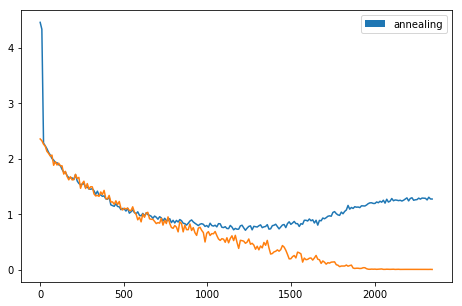

In [32]:
plt.figure(figsize=(17,17))
for i, result in enumerate(results_annealing):
    plt.subplot(3,2,i+1)
    array_toplot = result['loss_val']
    legend_string = f"annealing"
    x1 = np.linspace(1,step_it*2+anne_it*2,len(array_toplot))
    x2 = np.linspace(1,step_it*2+anne_it*2,len(result['loss_tr']))
    plt.plot(x1,array_toplot)
    plt.plot(x2,result['loss_tr'])
    plt.legend(handles=[mpatches.Patch(label=legend_string)])

In [ ]:
array_toplot[-1]

### now do proper training

### load-data

In [ ]:
batchsize = 128
dataloader_tr, dataloader_vl = load_cifar10(batchsize)

### network 

In [ ]:
%%capture
f"""To get ResNet56 use ResNet(BasicBlock,[9,9,9])""" 
resnet56 = ResNet(BasicBlock,[9,9,9])
if cuda_available: resnet56.cuda()

### loss-function    https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [ ]:
loss_xent = nn.CrossEntropyLoss()

### optimize-function https://pytorch.org/docs/stable/optim.html

In [ ]:
optimizer = optim.SGD(resnet56.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# play with forward and backwards pass

In [ ]:
start    = time.time()
f"""load previous model"""
# if os.path.isfile(load_filename):
#     resnet.load_state_dict(torch.load(load_filename))
n_epoch  = 1
validation_interval = 10

trainacc  = [] 
valacc    = [] 
trainloss = []
valloss   = [] 

for epoch in range(n_epoch):
    train_iterator = iter(train_data_loader)
    for i in range(len(train_iterator)):
        images, labels = train_iterator.next()
        
        f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
        if cuda_available: images, labels = images.cuda(), labels.cuda()
            
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, labels)
        
        trainacc = trainacc + [get_xent_acc(prediction, labels)]
        trainloss = trainloss + [output]
        
        f"""using zero_grad() seems to be necessary. step() does not clear the gradients"""
        optimizer.zero_grad()
        output.backward() # calculates gradients 
        optimizer.step()  # updates weights
        
        if i % validation_interval == 0:
            valacc, valloss = get_valacc(valacc, valloss)
            
    print(f"""time passed after training {epoch+1} epochs is {time.time()-start} seconds""")

### Plot results 

In [ ]:
x1, x2, x3 = [np.linspace(0, len(trainacc), num) for num in [len(trainloss), len(trainacc), len(valacc)]]

In [ ]:
plt.plot(x1,np.array(trainloss))
plt.show()

In [ ]:
plt.plot(x2,np.array(trainacc))
plt.plot(x3,np.array(valacc))
plt.show()

### Save/Load Model
### https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
%%capture 
f"""save"""
torch.save(resnet.state_dict(), save_filename)
f"""load"""
resnet2 = ResNet(BasicBlock,[9,9,9])
resnet2.load_state_dict(torch.load(load_filename))
compare_parameters(resnet,resnet2)

#### DenseNet

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
imshow(torchvision.utils.make_grid(images.cpu()))

In [ ]:
densenet = models.densenet161()